In [3]:
# from trainModel import *
import torch
from torchData import duneADCdata
from torch.utils.data import random_split
import matplotlib.pyplot as plt
# from SparseCNN import SparseNet
from torchvision import datasets, transforms
from torchDataSparse import duneADCdata, ToTensor
# import sparseconvnet as scn
from scipy.sparse import coo_matrix
# torch.manual_seed(1516989)

In [4]:
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import os
from skimage import io
import numpy as np
from scipy.sparse import coo_matrix
import torch.nn.functional as F
import sys

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, target = sample['input'], sample['target']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        # image = image.transpose((2, 0, 1))
        return {'input': torch.from_numpy(image),
                'target': target}  # torch.from_numpy(target)}


class myData(Dataset):
    def __init__(self, csv_file, root_dir, transform=None,batch_size=1,readFromFile = False):
        self.maxSize = 200
        self.data = pd.read_csv(csv_file)
        self.coords = []
        self.features = []
        self.targets = []
        self.root_dir = root_dir
        self.transform = transform
        
        if readFromFile:
            pass
        toolbar_width = len(self.data)
        sys.stdout.write("Loading dataset:\n")
        sys.stdout.flush()

        for i in range(len(self.data)):
            img_name = os.path.join(self.root_dir, self.data.iloc[i, 0])
            img = io.imread(img_name)
            img = coo_matrix(img)
            features = torch.FloatTensor(img.data)
#             features = img.data
            if features.size(0) <= self.maxSize and features.size(0) != 0:
                coordsx = img.row
                coordsy = img.col
                coords = np.dstack((coordsx,coordsy,np.zeros(features.size(0))))
                coords = torch.IntTensor(coords)
                pad1 = (0,self.maxSize-features.size(0))
                pad2 = (0,0,0,self.maxSize-features.size(0))
                coords = F.pad(coords,pad2,'constant',0)
                features = np.pad(features,pad1,'constant',constant_values=0)
                target = self.data.iloc[i, 1]
                self.coords.append(coords)
                self.features.append(features)
                self.targets.append(target)

            sys.stdout.write("{}%\r".format(int(i*100/(len(self.data)))))
            sys.stdout.flush()
#         self.coords = torch.cat(self.coords,0)
#         self.features  = torch.FloatTensor(self.features)
        print(self.targets)
#         self.targets  = torch.FloatTensor(self.targets)


    def __len__(self):
        return len(self.targets)#self.targets.size(0)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        sample = {"input": (self.coords[idx],self.features[idx]), "target": self.targets[idx]}
        
        if self.transform:
            sample = self.transform(sample)
        return sample
    

In [5]:
import torch
import torch.nn as nn
import sparseconvnet as scn
import torch.nn.functional as F

# from data import get_iterators

# two-dimensional SparseConvNet
class SparseNet(nn.Module):
    def __init__(self):
#         nn.Module.__init__(self)
#         self.sparseModel = scn.Sequential(
#             scn.SubmanifoldConvolution(2, 2000, 8, 3, False),
#             scn.MaxPooling(2, 3, 2),
#             scn.SparseResNet(2, 8, [
#                         ['b', 8, 2, 1],
#                         ['b', 16, 2, 2],
#                         ['b', 24, 2, 2],
#                         ['b', 32, 2, 2]]),
#             scn.Convolution(2, 32, 64, 5, 1, False),
#             scn.BatchNormReLU(64),
#             scn.SparseToDense(2, 64))
#         self.spatial_size= self.sparseModel.input_spatial_size(torch.LongTensor([1, 1]))
#         self.inputLayer = scn.InputLayer(2,self.spatial_size,2)
#         self.linear = nn.Linear(64, 2)
        nn.Module.__init__(self)
        self.sparseModel = scn.Sequential(
            scn.SubmanifoldConvolution(2, 200, 16, 3, False),
            scn.MaxPooling(2, 3, 2),
#             scn.SparseResNet(2, 8, [
#                         ['b', 8, 2, 1],
#                         ['b', 16, 2, 2],
#                         ['b', 24, 2, 2],
#                         ['b', 32, 2, 2]]),
            scn.Convolution(2, 16, 32, 5, 1, False),
# #             scn.BatchNormReLU(32),
            scn.MaxPooling(2, 3, 2),

            scn.SparseToDense(2, 32))
        self.spatial_size= self.sparseModel.input_spatial_size(torch.LongTensor([1, 1]))
#         print(self.spatial_size)
#         self.spatial_size=1500#torch.IntTensor(1500)
#         print(self.spatial_size)
        self.inputLayer = scn.InputLayer(dimension = 2,spatial_size = self.spatial_size)
#         self.linear = nn.Linear(16, 8)

        self.linear = nn.Linear(32, 2)

    def forward(self, x):
        x = self.inputLayer(x)
        x = self.sparseModel(x)
        x = x.view(-1, 32)
        x = F.softmax(self.linear(x))
        return x


In [6]:
class VGGNet(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)
        self.sparseModel = scn.Sequential(
        scn.SubmanifoldConvolution(2, 200, 8, 3, False),
          scn.SparseVggNet(2, 8, [
#             ['C', 8, ], ['C', 8], 'MP',
            ['C', 16], ['C', 16], 'MP',
            ['C', 16, 8], ['C', 16, 8], 'MP',
            ['C', 24, 8], ['C', 24, 8], 'MP']),
          scn.Convolution(2, 32, 64, 5, 1, False),
          scn.BatchNormReLU(64),
          scn.SparseToDense(2, 64))
        self.spatial_size= self.sparseModel.input_spatial_size(torch.LongTensor([1, 1]))
        self.inputLayer = scn.InputLayer(2,self.spatial_size,2)
        self.linear = nn.Linear(64, 2)

    def forward(self, x):
        x = self.inputLayer(x)
        x = self.sparseModel(x)
        x = x.view(-1, 64)
        x = F.softmax(self.linear(x))
        return x


In [7]:
import torch
# from torchData import duneADCdata, ToTensor

import sys
import torch.nn as nn
# import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
# from torchvision import datasets, transforms
import matplotlib.pyplot as plt
# from simpleCNN import Net


def train(net, trainloader, optimizer, batch_size=32, n_epochs=10, model_fname="model.pth",learning_rate = 0.001):
    criterion = nn.CrossEntropyLoss()
#     optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.0)
#     optimizer = optim.Adam(net.parameters(), lr=1e-2, betas=(0.9, 0.999), eps=1e-8,
#                  weight_decay=0, amsgrad=False)
    losses = []
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        toolbar_width = len(trainloader)
        running_loss = 0.0
        sys.stdout.write("Epoch {}/{}:\n".format(epoch+1,n_epochs))
        sys.stdout.write("[%s]" % (" " * toolbar_width))
        sys.stdout.flush()
        sys.stdout.write("\b" * (toolbar_width+1)) # return to start of line, after '['
        
        for i, data in enumerate(trainloader, 0):
#             sys.stdout.flush()

           
            inputs = data['input']
#             print(inputs)
#             print(inputs[0].size())
#             print(inputs[1].size())

#             if inputs[0].size(0) == batch_size:
            labels = data['target']
#             print(labels.size())
            optimizer.zero_grad()
            outputs = net(inputs)
#             print(outputs.size())
#             print(outputs)
#             print(labels)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            losses.append(loss.item())

            if i % 500 == 0:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss/500))
                running_loss = 0

    #                 losses.append(running_loss)
    #                 _, predicted = torch.max(outputs.data, 1)
    #                 print("Predicted: {}\nTarget: {}".format(predicted[j],labels[j]) for j in range(4))
    #                 #             print('Predicted: ', ' '.join('%5s' % predicted[j]
    #                 #                               for j in range(8)))
    #                 print("%: {}".format(outputs.data))
    #                 running_loss = 0.0
    #             sys.stdout.write("{}".format(loss.item()))
    #             sys.stdout.flush()
    #             sys.stdout.write("-\r")
    #             sys.stdout.flush()
            
        sys.stdout.write("]\n")
#         print('[%d, %5d] loss: %.3f' %
#                       (epoch + 1, i + 1, running_loss/batch_size))
    print('Finished Training')
    torch.save(net.state_dict(), "./model/"+model_fname)
    return (net,losses)


In [8]:
net = SparseNet()
# net = VGGNet()

# batch_size=32

In [9]:
transform = transforms.Compose([ToTensor()])
batch_size = 1#broken, use 1
# data = duneADCdata("seconddata.csv", "./",batch_size=batch_size)#, transform=transform)
# data = myData("babydata.csv", "./")
# data = myData("bigdata.csv", "./",batch_size=batch_size)#, transform=transform)
data = myData("bigdata_new-Copy1.csv", "./",batch_size=batch_size)#, transform=transform)
print(data[0])

Loading dataset:
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

{'input': (tensor([[[484, 633,   0],
         [564, 584,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
 

In [10]:
# batch_size = 31#broken, use 1
# data.targets[0:10] = [1 for _ in range(10)]
n_epochs=10
# batch_size = 4
classes = ["radio","SNB"]
lengths = [int(len(data)*0.8),int(len(data))-int(len(data)*0.8)]
trainData, testData= random_split(data,lengths)
trainLoader = DataLoader(trainData, batch_size=batch_size)#, shuffle=True)
testLoader = DataLoader(testData, batch_size=1)#, shuffle=True)
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.8,weight_decay=0.0000)

# batch_size = 1
print(data[0]['input'])

(tensor([[[484, 633,   0],
         [564, 584,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [ 

In [11]:
net,losses = train(net, trainLoader,optimizer,n_epochs=n_epochs,batch_size=batch_size,learning_rate=0.001)

Epoch 1/10:


[                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

[1,     1] loss: 0.001


/home/lewis/.conda/envs/SparseAIEnv/lib/python3.7/site-packages/ipykernel_launcher.py:53: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[1,   501] loss: 0.685
[1,  1001] loss: 0.687
[1,  1501] loss: 0.688
[1,  2001] loss: 0.686
[1,  2501] loss: 0.686
[1,  3001] loss: 0.686
[1,  3501] loss: 0.693
[1,  4001] loss: 0.688
[1,  4501] loss: 0.687
[1,  5001] loss: 0.686
[1,  5501] loss: 0.686
[1,  6001] loss: 0.692
[1,  6501] loss: 0.689
[1,  7001] loss: 0.688
[1,  7501] loss: 0.686
[1,  8001] loss: 0.691
[1,  8501] loss: 0.689
[1,  9001] loss: 0.686
[1,  9501] loss: 0.690
[1, 10001] loss: 0.684
[1, 10501] loss: 0.693
[1, 11001] loss: 0.685
[1, 11501] loss: 0.688
[1, 12001] loss: 0.688
[1, 12501] loss: 0.690
[1, 13001] loss: 0.688
[1, 13501] loss: 0.684
[1, 14001] loss: 0.691
[1, 14501] loss: 0.690
[1, 15001] loss: 0.684
[1, 15501] loss: 0.689
[1, 16001] loss: 0.691
[1, 16501] loss: 0.688
[1, 17001] loss: 0.688
[1, 17501] loss: 0.693
[1, 18001] loss: 0.686
[1, 18501] loss: 0.686
[1, 19001] loss: 0.686
[1, 19501] loss: 0.696
[1, 20001] loss: 0.691
[1, 20501] loss: 0.693
]
Epoch 2/10:


[                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

[2,   501] loss: 0.682
[2,  1001] loss: 0.686
[2,  1501] loss: 0.688
[2,  2001] loss: 0.686
[2,  2501] loss: 0.686
[2,  3001] loss: 0.686
[2,  3501] loss: 0.693
[2,  4001] loss: 0.688
[2,  4501] loss: 0.687
[2,  5001] loss: 0.686
[2,  5501] loss: 0.686
[2,  6001] loss: 0.692
[2,  6501] loss: 0.689
[2,  7001] loss: 0.688
[2,  7501] loss: 0.686
[2,  8001] loss: 0.691
[2,  8501] loss: 0.689
[2,  9001] loss: 0.686
[2,  9501] loss: 0.690
[2, 10001] loss: 0.684
[2, 10501] loss: 0.693
[2, 11001] loss: 0.685
[2, 11501] loss: 0.688
[2, 12001] loss: 0.688
[2, 12501] loss: 0.690
[2, 13001] loss: 0.688
[2, 13501] loss: 0.684
[2, 14001] loss: 0.691
[2, 14501] loss: 0.690
[2, 15001] loss: 0.684
[2, 15501] loss: 0.689
[2, 16001] loss: 0.691
[2, 16501] loss: 0.688
[2, 17001] loss: 0.688
[2, 17501] loss: 0.693
[2, 18001] loss: 0.686
[2, 18501] loss: 0.686
[2, 19001] loss: 0.686
[2, 19501] loss: 0.696
[2, 20001] loss: 0.691
[2, 20501] loss: 0.693
]
Epoch 3/10:


[                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

[3,   501] loss: 0.682
[3,  1001] loss: 0.686
[3,  1501] loss: 0.688
[3,  2001] loss: 0.686
[3,  2501] loss: 0.686
[3,  3001] loss: 0.686
[3,  3501] loss: 0.693
[3,  4001] loss: 0.688
[3,  4501] loss: 0.687
[3,  5001] loss: 0.686
[3,  5501] loss: 0.686
[3,  6001] loss: 0.692
[3,  6501] loss: 0.689
[3,  7001] loss: 0.688
[3,  7501] loss: 0.686
[3,  8001] loss: 0.691
[3,  8501] loss: 0.689
[3,  9001] loss: 0.686
[3,  9501] loss: 0.690
[3, 10001] loss: 0.684
[3, 10501] loss: 0.693
[3, 11001] loss: 0.685
[3, 11501] loss: 0.688
[3, 12001] loss: 0.688
[3, 12501] loss: 0.690
[3, 13001] loss: 0.688
[3, 13501] loss: 0.684
[3, 14001] loss: 0.691
[3, 14501] loss: 0.690
[3, 15001] loss: 0.684
[3, 15501] loss: 0.689
[3, 16001] loss: 0.691
[3, 16501] loss: 0.688
[3, 17001] loss: 0.688
[3, 17501] loss: 0.693
[3, 18001] loss: 0.686
[3, 18501] loss: 0.686
[3, 19001] loss: 0.686
[3, 19501] loss: 0.696
[3, 20001] loss: 0.691
[3, 20501] loss: 0.693
]
Epoch 4/10:


[                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

[4,   501] loss: 0.682
[4,  1001] loss: 0.686
[4,  1501] loss: 0.688
[4,  2001] loss: 0.686
[4,  2501] loss: 0.686
[4,  3001] loss: 0.686
[4,  3501] loss: 0.693
[4,  4001] loss: 0.688
[4,  4501] loss: 0.687
[4,  5001] loss: 0.686
[4,  5501] loss: 0.686
[4,  6001] loss: 0.692
[4,  6501] loss: 0.689
[4,  7001] loss: 0.688
[4,  7501] loss: 0.686
[4,  8001] loss: 0.691
[4,  8501] loss: 0.689
[4,  9001] loss: 0.686
[4,  9501] loss: 0.690
[4, 10001] loss: 0.684
[4, 10501] loss: 0.693
[4, 11001] loss: 0.685
[4, 11501] loss: 0.688
[4, 12001] loss: 0.688
[4, 12501] loss: 0.690
[4, 13001] loss: 0.688
[4, 13501] loss: 0.684
[4, 14001] loss: 0.691
[4, 14501] loss: 0.690
[4, 15001] loss: 0.684
[4, 15501] loss: 0.689
[4, 16001] loss: 0.691
[4, 16501] loss: 0.688
[4, 17001] loss: 0.688
[4, 17501] loss: 0.693
[4, 18001] loss: 0.686
[4, 18501] loss: 0.686
[4, 19001] loss: 0.686
[4, 19501] loss: 0.696
[4, 20001] loss: 0.691
[4, 20501] loss: 0.693
]
Epoch 5/10:


[                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

[5,   501] loss: 0.682
[5,  1001] loss: 0.686
[5,  1501] loss: 0.688
[5,  2001] loss: 0.686
[5,  2501] loss: 0.686
[5,  3001] loss: 0.686
[5,  3501] loss: 0.693
[5,  4001] loss: 0.688
[5,  4501] loss: 0.687
[5,  5001] loss: 0.686
[5,  5501] loss: 0.686
[5,  6001] loss: 0.692
[5,  6501] loss: 0.689
[5,  7001] loss: 0.688
[5,  7501] loss: 0.686
[5,  8001] loss: 0.691
[5,  8501] loss: 0.689
[5,  9001] loss: 0.686
[5,  9501] loss: 0.690
[5, 10001] loss: 0.684
[5, 10501] loss: 0.693
[5, 11001] loss: 0.685
[5, 11501] loss: 0.688
[5, 12001] loss: 0.688
[5, 12501] loss: 0.690
[5, 13001] loss: 0.688
[5, 13501] loss: 0.684
[5, 14001] loss: 0.691
[5, 14501] loss: 0.690
[5, 15001] loss: 0.684
[5, 15501] loss: 0.689
[5, 16001] loss: 0.691
[5, 16501] loss: 0.688
[5, 17001] loss: 0.688
[5, 17501] loss: 0.693
[5, 18001] loss: 0.686
[5, 18501] loss: 0.686
[5, 19001] loss: 0.686
[5, 19501] loss: 0.696
[5, 20001] loss: 0.691
[5, 20501] loss: 0.693
]
Epoch 6/10:


[                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

[6,   501] loss: 0.682
[6,  1001] loss: 0.686
[6,  1501] loss: 0.688
[6,  2001] loss: 0.686
[6,  2501] loss: 0.686
[6,  3001] loss: 0.686
[6,  3501] loss: 0.693
[6,  4001] loss: 0.688
[6,  4501] loss: 0.687
[6,  5001] loss: 0.686
[6,  5501] loss: 0.686
[6,  6001] loss: 0.692
[6,  6501] loss: 0.689
[6,  7001] loss: 0.688
[6,  7501] loss: 0.686
[6,  8001] loss: 0.691
[6,  8501] loss: 0.689
[6,  9001] loss: 0.686
[6,  9501] loss: 0.690
[6, 10001] loss: 0.684
[6, 10501] loss: 0.693
[6, 11001] loss: 0.685
[6, 11501] loss: 0.688
[6, 12001] loss: 0.688
[6, 12501] loss: 0.690
[6, 13001] loss: 0.688
[6, 13501] loss: 0.684
[6, 14001] loss: 0.691
[6, 14501] loss: 0.690
[6, 15001] loss: 0.684
[6, 15501] loss: 0.689
[6, 16001] loss: 0.691
[6, 16501] loss: 0.688
[6, 17001] loss: 0.688
[6, 17501] loss: 0.693
[6, 18001] loss: 0.686
[6, 18501] loss: 0.686
[6, 19001] loss: 0.686
[6, 19501] loss: 0.696
[6, 20001] loss: 0.691
[6, 20501] loss: 0.693
]
Epoch 7/10:


[                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

[7,   501] loss: 0.682
[7,  1001] loss: 0.686
[7,  1501] loss: 0.688
[7,  2001] loss: 0.686
[7,  2501] loss: 0.686
[7,  3001] loss: 0.686
[7,  3501] loss: 0.693
[7,  4001] loss: 0.688
[7,  4501] loss: 0.687
[7,  5001] loss: 0.686
[7,  5501] loss: 0.686
[7,  6001] loss: 0.692
[7,  6501] loss: 0.689
[7,  7001] loss: 0.688
[7,  7501] loss: 0.686
[7,  8001] loss: 0.691
[7,  8501] loss: 0.689
[7,  9001] loss: 0.686
[7,  9501] loss: 0.690
[7, 10001] loss: 0.684
[7, 10501] loss: 0.693
[7, 11001] loss: 0.685
[7, 11501] loss: 0.688
[7, 12001] loss: 0.688
[7, 12501] loss: 0.690
[7, 13001] loss: 0.688
[7, 13501] loss: 0.684
[7, 14001] loss: 0.691
[7, 14501] loss: 0.690
[7, 15001] loss: 0.684
[7, 15501] loss: 0.689
[7, 16001] loss: 0.691
[7, 16501] loss: 0.688
[7, 17001] loss: 0.688
[7, 17501] loss: 0.693
[7, 18001] loss: 0.686
[7, 18501] loss: 0.686
[7, 19001] loss: 0.686
[7, 19501] loss: 0.696
[7, 20001] loss: 0.691
[7, 20501] loss: 0.693
]
Epoch 8/10:


[                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

[8,   501] loss: 0.682
[8,  1001] loss: 0.686
[8,  1501] loss: 0.688
[8,  2001] loss: 0.686
[8,  2501] loss: 0.686
[8,  3001] loss: 0.686
[8,  3501] loss: 0.693
[8,  4001] loss: 0.688
[8,  4501] loss: 0.687
[8,  5001] loss: 0.686
[8,  5501] loss: 0.686
[8,  6001] loss: 0.692
[8,  6501] loss: 0.689
[8,  7001] loss: 0.688
[8,  7501] loss: 0.686
[8,  8001] loss: 0.691
[8,  8501] loss: 0.689
[8,  9001] loss: 0.686
[8,  9501] loss: 0.690
[8, 10001] loss: 0.684
[8, 10501] loss: 0.693
[8, 11001] loss: 0.685
[8, 11501] loss: 0.688
[8, 12001] loss: 0.688
[8, 12501] loss: 0.690
[8, 13001] loss: 0.688
[8, 13501] loss: 0.684
[8, 14001] loss: 0.691
[8, 14501] loss: 0.690
[8, 15001] loss: 0.684
[8, 15501] loss: 0.689
[8, 16001] loss: 0.691
[8, 16501] loss: 0.688
[8, 17001] loss: 0.688
[8, 17501] loss: 0.693
[8, 18001] loss: 0.686
[8, 18501] loss: 0.686
[8, 19001] loss: 0.686
[8, 19501] loss: 0.696
[8, 20001] loss: 0.691
[8, 20501] loss: 0.693
]
Epoch 9/10:


[                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

[9,   501] loss: 0.682
[9,  1001] loss: 0.686
[9,  1501] loss: 0.688
[9,  2001] loss: 0.686
[9,  2501] loss: 0.686
[9,  3001] loss: 0.686
[9,  3501] loss: 0.693
[9,  4001] loss: 0.688
[9,  4501] loss: 0.687
[9,  5001] loss: 0.686
[9,  5501] loss: 0.686
[9,  6001] loss: 0.692
[9,  6501] loss: 0.689
[9,  7001] loss: 0.688
[9,  7501] loss: 0.686
[9,  8001] loss: 0.691
[9,  8501] loss: 0.689
[9,  9001] loss: 0.686
[9,  9501] loss: 0.690
[9, 10001] loss: 0.684
[9, 10501] loss: 0.693
[9, 11001] loss: 0.685
[9, 11501] loss: 0.688
[9, 12001] loss: 0.688
[9, 12501] loss: 0.690
[9, 13001] loss: 0.688
[9, 13501] loss: 0.684
[9, 14001] loss: 0.691
[9, 14501] loss: 0.690
[9, 15001] loss: 0.684
[9, 15501] loss: 0.689
[9, 16001] loss: 0.691
[9, 16501] loss: 0.688
[9, 17001] loss: 0.688
[9, 17501] loss: 0.693
[9, 18001] loss: 0.686
[9, 18501] loss: 0.686
[9, 19001] loss: 0.686
[9, 19501] loss: 0.696
[9, 20001] loss: 0.691
[9, 20501] loss: 0.693
]
Epoch 10/10:


[                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

[10,   501] loss: 0.682
[10,  1001] loss: 0.686
[10,  1501] loss: 0.688
[10,  2001] loss: 0.686
[10,  2501] loss: 0.686
[10,  3001] loss: 0.686
[10,  3501] loss: 0.693
[10,  4001] loss: 0.688
[10,  4501] loss: 0.687
[10,  5001] loss: 0.686
[10,  5501] loss: 0.686
[10,  6001] loss: 0.692
[10,  6501] loss: 0.689
[10,  7001] loss: 0.688
[10,  7501] loss: 0.686
[10,  8001] loss: 0.691
[10,  8501] loss: 0.689
[10,  9001] loss: 0.686
[10,  9501] loss: 0.690
[10, 10001] loss: 0.684
[10, 10501] loss: 0.693
[10, 11001] loss: 0.685
[10, 11501] loss: 0.688
[10, 12001] loss: 0.688
[10, 12501] loss: 0.690
[10, 13001] loss: 0.688
[10, 13501] loss: 0.684
[10, 14001] loss: 0.691
[10, 14501] loss: 0.690
[10, 15001] loss: 0.684
[10, 15501] loss: 0.689
[10, 16001] loss: 0.691
[10, 16501] loss: 0.688
[10, 17001] loss: 0.688
[10, 17501] loss: 0.693
[10, 18001] loss: 0.686
[10, 18501] loss: 0.686
[10, 19001] loss: 0.686
[10, 19501] loss: 0.696
[10, 20001] loss: 0.691
[10, 20501] loss: 0.693
]
Finished Train

In [ ]:
# data[0]
it = {'train':trainLoader,'val':testLoader}
scn.ClassificationTrainValidate(
    net, it,
    {'n_epochs': 1,
     'initial_lr': 0.001,
     'lr_decay': 0.001,
     'weight_decay': 0.5,
     'use_cuda': torch.cuda.is_available(),
     'check_point': False, })


In [ ]:
net.load_state_dict(torch.load("./model/model.pth"))


[0.68812328 0.68792605 0.68792605 0.68792604 0.68792604 0.68792604
 0.68792604 0.68792604 0.68792604 0.68792604]


/home/lewis/.conda/envs/SparseAIEnv/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  # Remove the CWD from sys.path while we load stuff.
/home/lewis/.conda/envs/SparseAIEnv/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


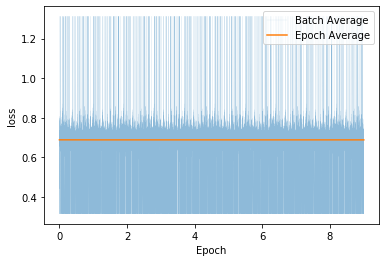

In [52]:
n = 9
x = np.linspace(0,n,len(losses))
plt.plot(x,losses,linewidth=0.1,alpha=0.5,label="Batch Average")
plt.xlabel("Epoch")
plt.ylabel("loss")
avg_losses = np.mean(np.reshape(np.array(losses),(n+1,-1)),axis=1)
print(avg_losses)
plt.plot(avg_losses,label="Epoch Average")
plt.legend()
plt.savefig("SCNNloss.png",bbox_inches='tight',dpi=500)
# plt.show()

[0.68812328 0.68792605 0.68792605 0.68792604 0.68792604 0.68792604
 0.68792604 0.68792604 0.68792604 0.68792604]


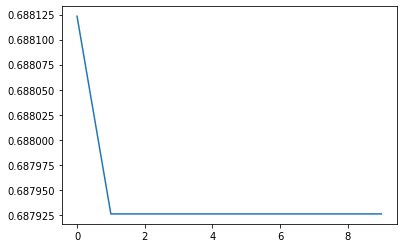

In [32]:
avg_losses = np.mean(np.reshape(np.array(losses),(10,-1)),axis=1)
print(avg_losses)
plt.plot(avg_losses)
# plt.savefig("SCNNloss.png",bbox_inches='tight',dpi=500)
plt.show()

In [13]:
import time
dataiter = iter(testLoader)
true = []
predict = []
times = [[],[]]
for d in dataiter:
    images = d['input']
    labels = d['target']
    t = time.clock()
    outputs = net(images)
    t1 = time.clock()
    times[0].append(t1-t)
    times[1].append(len(d))
#     _, predicted = torch.max(outputs, 1)
#     print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
#                               for j in range(4)))
#     predict.append(predicted)
#     true.append(labels)
    
times_np = np.array(times)
avgtime = np.mean(times_np[0])#/times_np[1])
error = np.std(times_np[0])/np.sqrt(len(times))
print("Average time per image: {} pm {}".format(avgtime,error))

/home/lewis/.conda/envs/SparseAIEnv/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  if __name__ == '__main__':
/home/lewis/.conda/envs/SparseAIEnv/lib/python3.7/site-packages/ipykernel_launcher.py:53: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/lewis/.conda/envs/SparseAIEnv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # This is added back by InteractiveShellApp.init_path()


Average time per image: 0.024680272108862544 pm 0.004704060727645754


In [1]:
print(times_np)

NameError: name 'times_np' is not defined

In [29]:
correct = 0
total = 0
snb = 0
radio = 0
with torch.no_grad():
    for d in testLoader:
        images = d ['input']
        labels = d ['target']
        outputs = net(images)
        print(outputs.data)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        snb += (predicted == 1).sum().item()
        radio += (predicted == 0).sum().item()

        
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))
print("SNB: {}".format(snb))
print("Radio: {}".format(radio))

tensor([[0.4153, 0.5847]])
tensor([[0.4153, 0.5847]])
tensor([[0.4153, 0.5847]])
tensor([[0.4153, 0.5847]])
Accuracy of the network on the 10000 test images: 25 %
SNB: 4
Radio: 0


/home/lewis/.conda/envs/SparseAIEnv/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [13]:
from sklearn.metrics import confusion_matrix
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testLoader:
        images = data['input']
        labels = data['target']
        
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(2):
            label = classes[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))



TypeError: list indices must be integers or slices, not str

In [ ]:
import seaborn as sn
df_cm = pd.DataFrame(cm, range(6), range(6))
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.show()